In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC

#### Load Data -- Continuous

In [2]:
train_pd = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/train.csv")
test_pd = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/broward/data/test.csv")
test_pd = test_pd[test_pd['p_age_first_offense'] != 0]

In [3]:
x_train, y_train = train_pd.values[:,:-1], train_pd.values[:,-1]
x_test, y_test = test_pd.values[:,:-1], test_pd.values[:,-1]

In [4]:
cols = train_pd.columns[:-1]

#### Modeling

In [5]:
ebm = ExplainableBoostingClassifier(feature_names=cols, n_estimators=40, 
                                    max_tree_splits=4, holdout_size=0.1, holdout_split=0.1).fit(x_train, y_train)

In [6]:
ebm.score(x_train, y_train)

0.6845809341010877

In [7]:
ebm.score(x_test, y_test)

0.6424731182795699

In [8]:
ebm_global = ebm.explain_global(name = 'EBM')
show(ebm_global)

### CV

In [9]:
combined = np.r_[train_pd, test_pd]
X, Y = combined[:, :-1], combined[:,-1]

Text(0,0.5,'True Positive Rate')

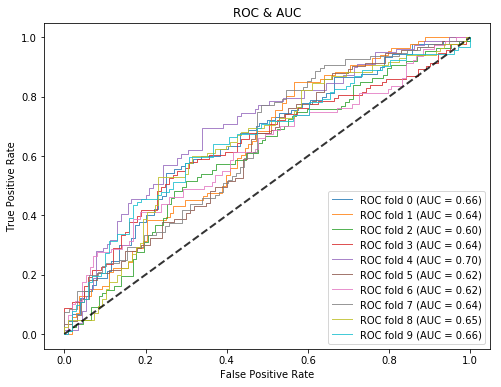

In [14]:
cv = KFold(n_splits=10, random_state=816, shuffle=True)
classifier = ExplainableBoostingClassifier(feature_names=cols, n_estimators=60, 
                                    max_tree_splits=4, holdout_size=0.1, holdout_split=0.1)
train_acc = []
test_acc = []

i = 0
plt.figure(figsize=(8,6))
for train, test in cv.split(X, Y):
    X_train, Y_train = X[train], Y[train]
    X_test, Y_test = X[test], Y[test]
    
    model = classifier.fit(X_train, Y_train)
    test_prob = model.predict_proba(X_test)[:,1]
    
    train_acc.append(model.score(X_train, Y_train))
    test_acc.append(model.score(X_test, Y_test))
    
    ## compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(Y_test, test_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, alpha=0.8, 
             label = 'ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], lw=2, linestyle = '--',color='black',alpha=.8)
plt.title("ROC & AUC")
plt.legend(loc = "lower right")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [15]:
np.mean(train_acc), np.mean(test_acc)

(0.6886009465771482, 0.6077292879653866)

In [12]:
train_acc

[0.6812176909821941,
 0.6840896036760482,
 0.6806433084434234,
 0.6961516369902355,
 0.6863871338311315,
 0.6980482204362801,
 0.6854190585533869,
 0.6848450057405281,
 0.687715269804822,
 0.7014925373134329]

In [13]:
test_acc

[0.6185567010309279,
 0.5670103092783505,
 0.6030927835051546,
 0.6185567010309279,
 0.6752577319587629,
 0.5647668393782384,
 0.616580310880829,
 0.5647668393782384,
 0.616580310880829,
 0.6321243523316062]